[dataset: FSD50k (Free Sound Dataset 50k)](https://zenodo.org/record/4060432#.X5ySHHhKgWo)


# Modeling

This notebook is broken up into three sections for the three sets of extracted features: Mel-Frequency Spectrograms, MFCC Spectrograms, and the mean MFCC values. All models with have the same response variable of the audio class label.

#### Part 1:
Features: Mel-Frequency Spectrograms<br>
- Model 1a: Convolutional Neural Network <br>

#### Part 2: 
Features: MFCC Sprectrograms
- Model 2a: Convolutional Nueral Network
- Model 2b: CNN with Resnet50 Tranfering Learning 

#### Part 3: 
Features: Mean MFCC Values
- Model 3a: Neural Network
- Model 3b: Logistic Regression
- Model 3c: Random Forest
- Model 4b: Support Vector Machine

Thesis: Classify raw audio files into categories associated with household noises to identify emergency related sounds(humans (voice), animals, instruments, water, door, car, explosion (boom, thunder).

In [9]:
import pandas as pd
import numpy as np
import time
import IPython.display as ipd
import matplotlib.pyplot as plt
from PIL import Image
import skimage.io
import os
import pickle
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras import optimizers
from keras.optimizers import Adam, SGD
from keras.layers import LeakyReLU
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [27]:
from keras.losses import sparse_categorical_crossentropy
from keras.layers import BatchNormalization
from keras.layers import UpSampling2D 
from keras.layers import GlobalAveragePooling2D
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD
from keras.layers import LeakyReLU
from keras.applications.resnet50 import ResNet50
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support

### Loading Meta Data

In [11]:
dev_info = pd.read_json('data/labelled_dev_info.json')
eval_info = pd.read_json('data/labelled_eval_info.json')
dev_synth_info = pd.read_json('data/dev_info_resamp.json')

In [ ]:
class_names_list = ['human', 'noise', 'animal', 'music', 'ambient', 'alarm', 'movement', 'other']

class_labels_dict= {0:'human',
                    1:'noise',
                    2:'animal',
                    3:'music',
                    4:'ambient',
                    5:'alarm',
                    6:'movement',
                    7:'other'
                    }

## Part 1: Mel-Frequency Spectograms Features

## Model: Convolutional Neural Network


In [14]:
# load data into generator with keras function .flow_from_directory

train_datagen=ImageDataGenerator(rescale=1./255.)  # , default: validation_split= None
# 25% test set before, thats why only 75 before, seperate  eval so validiation =0


train_spec_generator=train_datagen.flow_from_dataframe(
    dataframe= dev_synth_info,
    directory= 'data/train_spectrograms',
    x_col='png_name',
    y_col= 'labels', 
    color_mode="grayscale",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode=  "raw", #  'raw' for numeric input
    target_size=(128,216),
    subset='training',
    validate_filenames=True) # target_size=(64,64)) tuple of height/width

# test generator
test_datagen=ImageDataGenerator(rescale=1./255.)

test_spec_generator=test_datagen.flow_from_dataframe(
    dataframe= eval_info,
    directory= 'data/test_spectrograms',
    x_col='png_name',
    y_col= 'labels',
    color_mode="grayscale",
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode=  "raw", # 'raw' for numeric input
    target_size=(128,216),
    validate_filenames=True) # target_size=(64,64)) tuple of height/width

Found 40000 validated image filenames.
Found 10231 validated image filenames.


In [15]:
#Define Model
model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(128,216,1))) # Height, Width, Num_channels
model.add(MaxPooling2D(pool_size=(1, 2)))
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu')) # Height, Width, Num_channels
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))

# optimizer=tf.keras.optimizers.adam() didnt work...
optimizer = optimizers.SGD(lr=0.002, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss=keras.losses.sparse_categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 214, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 107, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 105, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 52, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 25, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 23, 32)        9

In [16]:
#Train and Test The Model
start= time.time()
history = model.fit(x=train_spec_generator, validation_data=test_spec_generator, epochs=20, verbose=1)    # switched to 5 from 10

end =time.time()
print(end-start)

Epoch 1/20
1250/1250 [==============================] - 117s 93ms/step - loss: 2.0714 - accuracy: 0.1410 - val_loss: 2.0610 - val_accuracy: 0.1469
Epoch 2/20
1250/1250 [==============================] - 116s 93ms/step - loss: 1.9868 - accuracy: 0.2189 - val_loss: 1.9555 - val_accuracy: 0.2516
Epoch 3/20
1250/1250 [==============================] - 116s 93ms/step - loss: 1.8338 - accuracy: 0.3075 - val_loss: 1.8126 - val_accuracy: 0.3541
Epoch 4/20
1250/1250 [==============================] - 117s 93ms/step - loss: 1.6679 - accuracy: 0.3875 - val_loss: 1.7409 - val_accuracy: 0.3694
Epoch 5/20
1250/1250 [==============================] - 116s 93ms/step - loss: 1.5576 - accuracy: 0.4375 - val_loss: 1.7635 - val_accuracy: 0.3431
Epoch 6/20
1250/1250 [==============================] - 116s 93ms/step - loss: 1.4833 - accuracy: 0.4687 - val_loss: 1.7710 - val_accuracy: 0.3410
Epoch 7/20
1250/1250 [==============================] - 116s 93ms/step - loss: 1.4110 - accuracy: 0.5001 - val_loss: 1

In [17]:
# Evaluating Testing Data

spectrogram_preds = model.predict(test_spec_generator)
spectrogram_preds = np.argmax(spectrogram_preds, axis=1)

### Model Analysis

classification Report:
              precision    recall  f1-score   support

           0       0.39      0.72      0.51      1413
           1       0.71      0.45      0.55      4206
           2       0.35      0.35      0.35       829
           3       0.58      0.74      0.65      1168
           4       0.44      0.58      0.50      1559
           5       0.30      0.21      0.25       378
           6       0.40      0.31      0.35       110
           7       0.07      0.04      0.05       568

    accuracy                           0.50     10231
   macro avg       0.41      0.42      0.40     10231
weighted avg       0.53      0.50      0.49     10231



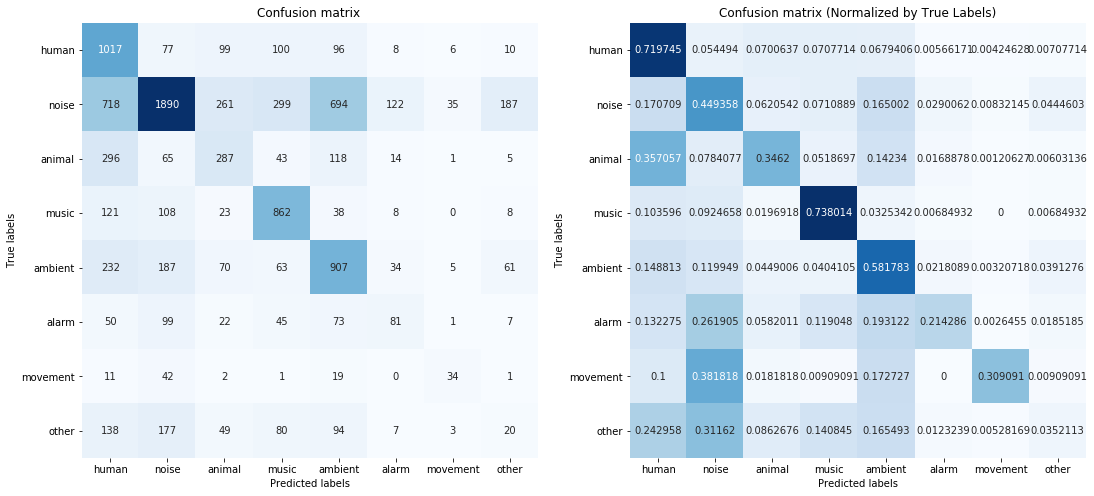

In [18]:
#Classification Report: 
print("classification Report:")
print(classification_report(eval_info.labels, spectrogram_preds))

# Confusion Matrix
fig=plt.figure()

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
# fig1=plt.figure(figsize=(5,10))
# fig2=plt.figure(figsize=(5,10))


fig.set_size_inches(18,8)
sns.heatmap(confusion_matrix(eval_info.labels, spectrogram_preds, normalize=None),
            annot=True, fmt='g', cmap='Blues', cbar=False, ax=ax1)

ax1.set_xlabel("Predicted labels")
ax1.set_ylabel("True labels")
ax1.set_title('Confusion matrix ')
ax1.set_xticklabels(class_names_list)
ax1.set_yticklabels(class_names_list, rotation='horizontal')

sns.heatmap(confusion_matrix(eval_info.labels, spectrogram_preds, normalize='true'),  
            annot=True, fmt='g', cmap='Blues', cbar=False, ax=ax2)
ax2.set_xlabel("Predicted labels")
ax2.set_ylabel("True labels")
ax2.set_title('Confusion matrix (Normalized by True Labels)')
ax2.set_xticklabels(class_names_list)
ax2.set_yticklabels(class_names_list, rotation='horizontal')


plt.show()
# or mfcc_test_generator.classes ?

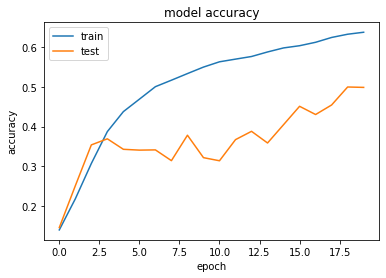

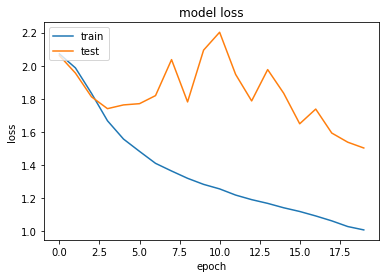

In [19]:
# Call back history for graphing
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### [save model, metrics, and history here]
____

## Part 2a: MFCC Spectograms Features
## Model: Convolutional Neural Network


In [20]:
# loading MFCC Spectrograms into train and test generators

datagen=ImageDataGenerator(rescale=1./255.)       #validation_split=0.2

mfcc_train_generator=datagen.flow_from_dataframe(
    dataframe= dev_synth_info,
    directory= 'data/train_mfcc',
    x_col='png_name',
    y_col= 'labels',
    color_mode="grayscale",
    batch_size=32,
    seed=42,
    shuffle=True,
    subset='training',
    class_mode="raw", 
    target_size=(32,216)) # target_size=(64,64)) tuple of height/width

# test generator
datagen=ImageDataGenerator(rescale=1./255.)

mfcc_test_generator=datagen.flow_from_dataframe(
    dataframe= eval_info,
    directory= 'data/test_mfcc',
    x_col='png_name',
    y_col= 'labels',
    color_mode="grayscale",
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode="raw", 
    target_size=(32,216)) # target_size=(64,64)) tuple of height/width

Found 40000 validated image filenames.
Found 10231 validated image filenames.


In [21]:
# rerun this with consistent pool size of (2,2)

In [24]:
model = Sequential()

model.add(Conv2D(8, kernel_size=(3, 3), activation='relu', padding="same", input_shape=(32, 216,1)))
model.add(MaxPooling2D(pool_size=(1, 2)))
model.add(Conv2D(8, kernel_size=(3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=(1, 2)))

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=(1, 2)))
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding="same"))
model.add(Dropout(0.25))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding="same"))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))

optimizer = SGD(lr=0.002, decay=1e-6, momentum=0.9, nesterov=True)


model.compile(loss=sparse_categorical_crossentropy,
              optimizer=optimizer,
              metrics='accuracy')

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 32, 216, 8)        80        
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 108, 8)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 108, 8)        584       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 32, 54, 8)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 54, 16)        1168      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 27, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 27, 16)       

#### addding classes weights to model (currently disabled)

In [25]:
# class_weights = dict(40966 / (8 *dev_info.labels.value_counts()))

# # tuning: scaled back the weights of the minority classes (still within the same proportions of the training data)

# tuned_class_weights= {
#      1: 1,
#      3: 1,
#      0: 1,
#      4: 1,
#      2: 1,
#      5: 2,
#      7: 2,
#      6: 2}

In [29]:
start =time.time()

# class_weight=tuned_class_weights (disabled currently)

history = model.fit(x=mfcc_train_generator, validation_data=mfcc_test_generator,
                    callbacks=[EarlyStopping(monitor='val_accuracy', mode='max',
                     min_delta=1, patience=50)], epochs=10,
                     verbose=1)   

end = time.time()
print(end - start)

Epoch 1/10
1250/1250 [==============================] - 53s 43ms/step - loss: 1.9235 - accuracy: 0.2495 - val_loss: 1.9435 - val_accuracy: 0.2792
Epoch 2/10
1250/1250 [==============================] - 26s 20ms/step - loss: 1.7025 - accuracy: 0.3750 - val_loss: 1.7853 - val_accuracy: 0.3223
Epoch 3/10
1250/1250 [==============================] - 26s 20ms/step - loss: 1.6246 - accuracy: 0.4099 - val_loss: 1.8279 - val_accuracy: 0.3225
Epoch 4/10
1250/1250 [==============================] - 26s 20ms/step - loss: 1.5659 - accuracy: 0.4357 - val_loss: 1.6693 - val_accuracy: 0.3863
Epoch 5/10
1250/1250 [==============================] - 26s 20ms/step - loss: 1.5186 - accuracy: 0.4529 - val_loss: 1.6340 - val_accuracy: 0.3979
Epoch 6/10
1250/1250 [==============================] - 26s 20ms/step - loss: 1.4801 - accuracy: 0.4689 - val_loss: 1.7424 - val_accuracy: 0.3648
Epoch 7/10
1250/1250 [==============================] - 26s 20ms/step - loss: 1.4367 - accuracy: 0.4854 - val_loss: 1.6789 -

In [ ]:
# Calculating predictions for test set
mfcc_preds = model.predict(mfcc_test_generator, verbose=1)
mfcc_preds = np.argmax(mfcc_preds, axis=1)

In [ ]:
#Classification Report: 
print("classification Report:")
print(classification_report(eval_info.labels, mfcc_preds))

#### [question] should include confusion matrix here or only in final notebook?

#### [save model, metrics, and history here]
____

## Part 2b: MFCC Spectograms Features
## Model: CNN Transfer Learning with ResNet50

In [ ]:
# have to instaniate image generators to import images with 3 channels (rbg) to fit Resnet50 hyperparameters:

train_datagen=ImageDataGenerator(rescale=1./255.)       
mfcc_resnet_train_generator=train_datagen.flow_from_dataframe(
    dataframe= dev_synth_info,
    directory= 'data/train_mfcc',
    x_col='png_no_aug',
    y_col= 'labels',
    color_mode="rgb",
    batch_size=64,
    seed=42,
    shuffle=True,
    subset='training',
    class_mode="raw", 
    target_size=(32,216)) 

# test generator
test_datagen=ImageDataGenerator(rescale=1./255.)
mfcc_resnet_test_generator=test_datagen.flow_from_dataframe(
    dataframe= eval_info,
    directory= 'data/test_mfcc',
    x_col='png_name',
    y_col= 'labels',
    color_mode="rgb",
    batch_size=64,
    seed=42,
    shuffle=False,
    class_mode="raw", 
    target_size=(32,216)) 

In [ ]:
# loading ResNet50 Model with ImageNet Weights

resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(32,216,3))   

# Removing final output layer to add customized trainable layers
output = resnet.layers[-1].output
output = keras.layers.Flatten()(output)
resnet = Model(inputs=resnet.input, outputs=output)


# # commented out code is for a frozen resnet model, and uncommented is for tuneable resnet weights.
# for layer in resnet.layers:
#     layer.trainable = False

for layer in resnet.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False
        
        
# summary of Resnet50 model:
resnet.summary() 

In [ ]:
#instantiating an empty model, loading Resnet50 layers and weights, adding 2 custom layers and an output layer.

model = Sequential()
model.add(resnet)
model.add(Dense(512, activation='relu', input_dim=(32,216,3)))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(8, activation='softmax'))

model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True),
              metrics='accuracy')

model.summary()

In [ ]:
start =time.time()

resnet_history = model.fit(x=mfcc_train_generator, validation_data=mfcc_test_generator,
                    epochs= 10, workers=36, verbose=1)   

end = time.time()
print(end - start)

In [ ]:
# making predictions on test set

resnet_preds = model.predict(mfcc_test_generator)
resnet_preds = np.argmax(resnet_preds, axis=1)

In [ ]:
#Classification Report: 
print("classification Report:")
print(classification_report(eval_info.labels, resnet_preds))

### [saved model, etc.]
___

## Part 3
- In this section we will use the feature set of the mean MFCC values. -
- This is the average of the Mel-Frequency Cepstrum Coefficients aggegrated over time. Thus for each audio event we have 32 MFC coefficients. 
- Now that no longer have an image but rather a 1-d array of features, we can apply standard classification algorithms to these features. 
- In the section we will train a standard Neural Network, Logistic Regression, Random Forest, and Support Vector Machine Classifier.

#### loading Training and Test Features: Numpy Arrays of Mean MFCC values  

In [ ]:
# loading Training and Testing Data features: Numpy Arrays of Mean MFCC values
    
X_train = np.load('data/train_mean_mfcc.npz')['arr_0']
X_train_resamp = np.load('data/train_resamp_mean_mfcc_values.npz')['arr_0']
X_test = np.load('data/test_mean_mfcc.npz')['arr_0']
X_test_aug = np.load('data/test_augmented_mean_mfcc_values.npz')['arr_0']

# declaring target variable:

y_train = dev_info['labels'].to_numpy()
y_test = eval_info['labels'].to_numpy()
y_train_resamp = dev_info_resamp['labels'].to_numpy()

# scaling features and assigning indices 

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_train_resamp = scaler.fit_transform(X_train_resamp)
X_test = scaler.fit_transform(X_test)
X_test_aug = scaler.fit_transform(X_test_aug)

print(X_train.shape)
print(X_train_resamp.shape)
print(X_test.shape)
print(X_test_aug.shape)

print(y_train.shape)
print(y_train_resamp.shape)
print(y_test.shape)

### Part 3a: Mean MFCC Value Features
### Model: Neural Network

In [ ]:
model = Sequential()
model.add(Dense(16, input_dim=32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
#model.add(Dropout(0.25))
model.add(Dense(32, activation='relu'))
#model.add(Dropout(0.25))
#model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.25))
model.add(Dense(8, activation='softmax'))

# compile the keras model
model.compile(loss=keras.losses.sparse_categorical_crossentropy, optimizer='adam', metrics=['accuracy'])
model.summary()

In [ ]:
model.fit(X_train, y_train, validation_data = (X_test_aug, y_test), epochs=50, batch_size=32, verbose=1)

In [ ]:
# Making predictions on the test set

mean_mfcc_preds =  model.predict(X_test_aug)
mean_mfcc_preds = np.argmax(mean_mfcc_preds, axis=1)

In [ ]:
#Classification Report: 
print("classification Report:")
print(classification_report(eval_info.labels, mean_mfcc_preds))

#### [save model here]

### Part 3b: Mean MFCC Value Features
### Model: Logistic Regression
#### Hyperparameters:
- Regularization Penalty: Elastic Net (l1_ratio=0.5)
- Solver: SAGA (extension of Stochastic Average Gradient(SAG) descent with L1 regualization, generally faster than SAG)

In [ ]:
## Baseline Model: Logistic Regression

# saga= stochastic average gradient descent
lr = LogisticRegression(penalty= 'elasticnet', solver='saga', l1_ratio= 0.5, max_iter=500)
lr.fit(X_train_resamp, y_train_resamp)
lr_preds= lr.predict(X_test_aug)

print(classification_report(y_test, lr_preds))

### Part 3c: Mean MFCC Value Features
### Model: Random Forest
#### Hyperparameters:

- Tuning "n_estimators"(number of trees), "max_features"(number of features to analyze at each split), "max_depth"(number of levels in the tree)
- Employing a Random Grid Search with 3 fold Cross-Validation with 50 iterations

In [ ]:
# return to this article on tuning: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 20)] #originally 200-2000
# Number of features to consider at every split

#changed from 'auto ' to None as 'auto' is same as 'sqrt'
max_features = [None, 'sqrt'] 
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 50, num = 11)]
max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth}
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf}

In [ ]:
start = time.time()

# Using random grid to search for best hyperparameters

# Creating the base model to tune
rf = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 50 different combinations, and use all available cores
rf_random_cv = RandomizedSearchCV(estimator = rf, 
                                  param_distributions = random_grid, 
                                  n_iter = 50, 
                                  cv = 3, 
                                  verbose=1, 
                                  random_state=42, 
                                  n_jobs =-1)

# Fit the random search model
rf_random_cv.fit(X_train_resamp, y_train_resamp)

stop = time.time()
print(stop - start)

In [ ]:
print("Best Parameters:", rf_random_cv.best_params_)

In [ ]:
rf_preds = rf_random_cv.best_estimator_.predict(X_test)

#Classification Report: 
print("classification Report:")
print(classification_report(y_test, rf_preds))

#### Feature Importance

In [ ]:
# Impurity-based feature importances. The higher, the more important the feature. 
# The importance of a feature is computed as the (normalized) total reduction of 
# the criterion brought by that feature. It is also known as the Gini importance.
# Warning: impurity-based feature importances can be misleading for high cardinality 
# features (many unique values). 
# Consider sklearn.inspection.permutation_importance as an alternative.

plt.figure(figsize=(14,6))
sns.barplot(y=list(range(1,33)), x=rf_random_cv.best_estimator_.feature_importances_, orient='h')
plt.title('MFC Coefficient Feature Importance from Random Forest Model')

### Part 3c: Mean MFCC Value Features
### Model: Support Vector Machine Classifier
#### Hyperparameters:
 - Tuning the kernel with either "linear" or "rbf", "gamma" from a reciprocal distribution from 0.001 to 1, "C" from a uniform distributin from 0.1 to 100.
 - Employed a Random Grid Search with 3 fold Cross-Validation with 20 iterations.

In [ ]:
# alternatively:
start= time.time()

svc = SVC()

# Adding all values of hyperparameters in a list from which the values of hyperparameter
# will randomly inserted as hyperparameter
param_distributions = {"gamma": reciprocal(0.001, 1),
                       "C": uniform(0.1, 100), # 0.1 - 100
                      kernel': ['linear','rbf']} 
                       

svc_random_cv = RandomizedSearchCV(svc, 
                                   param_distributions, 
                                   n_iter=20, 
                                   verbose=2, 
                                   cv=3, 
                                   n_jobs =-1) 

svc_random_cv.fit(X_train_resamp, y_train_resamp)

end= time.time()
print(end - start)

## End | Notes Below